# Modified Swiss Dwellings

## Set paths

In [1]:
import os

# set data path and child paths
datapath = r'C:\Users\caspervanengel\OneDrive\Documents\PHD\1_data\swiss-dwellings\3.0.0\cvaad-challenge\train'

path = {
    "full": datapath,
    "graph_in": os.path.join(datapath, 'graph_in'),
    "struct_in": os.path.join(datapath, 'struct_in'),
    "full_out": os.path.join(datapath, 'full_out'),
    "graph_out": os.path.join(datapath, 'graph_out')
}

## Load, print, and plot examples

### Required structural components

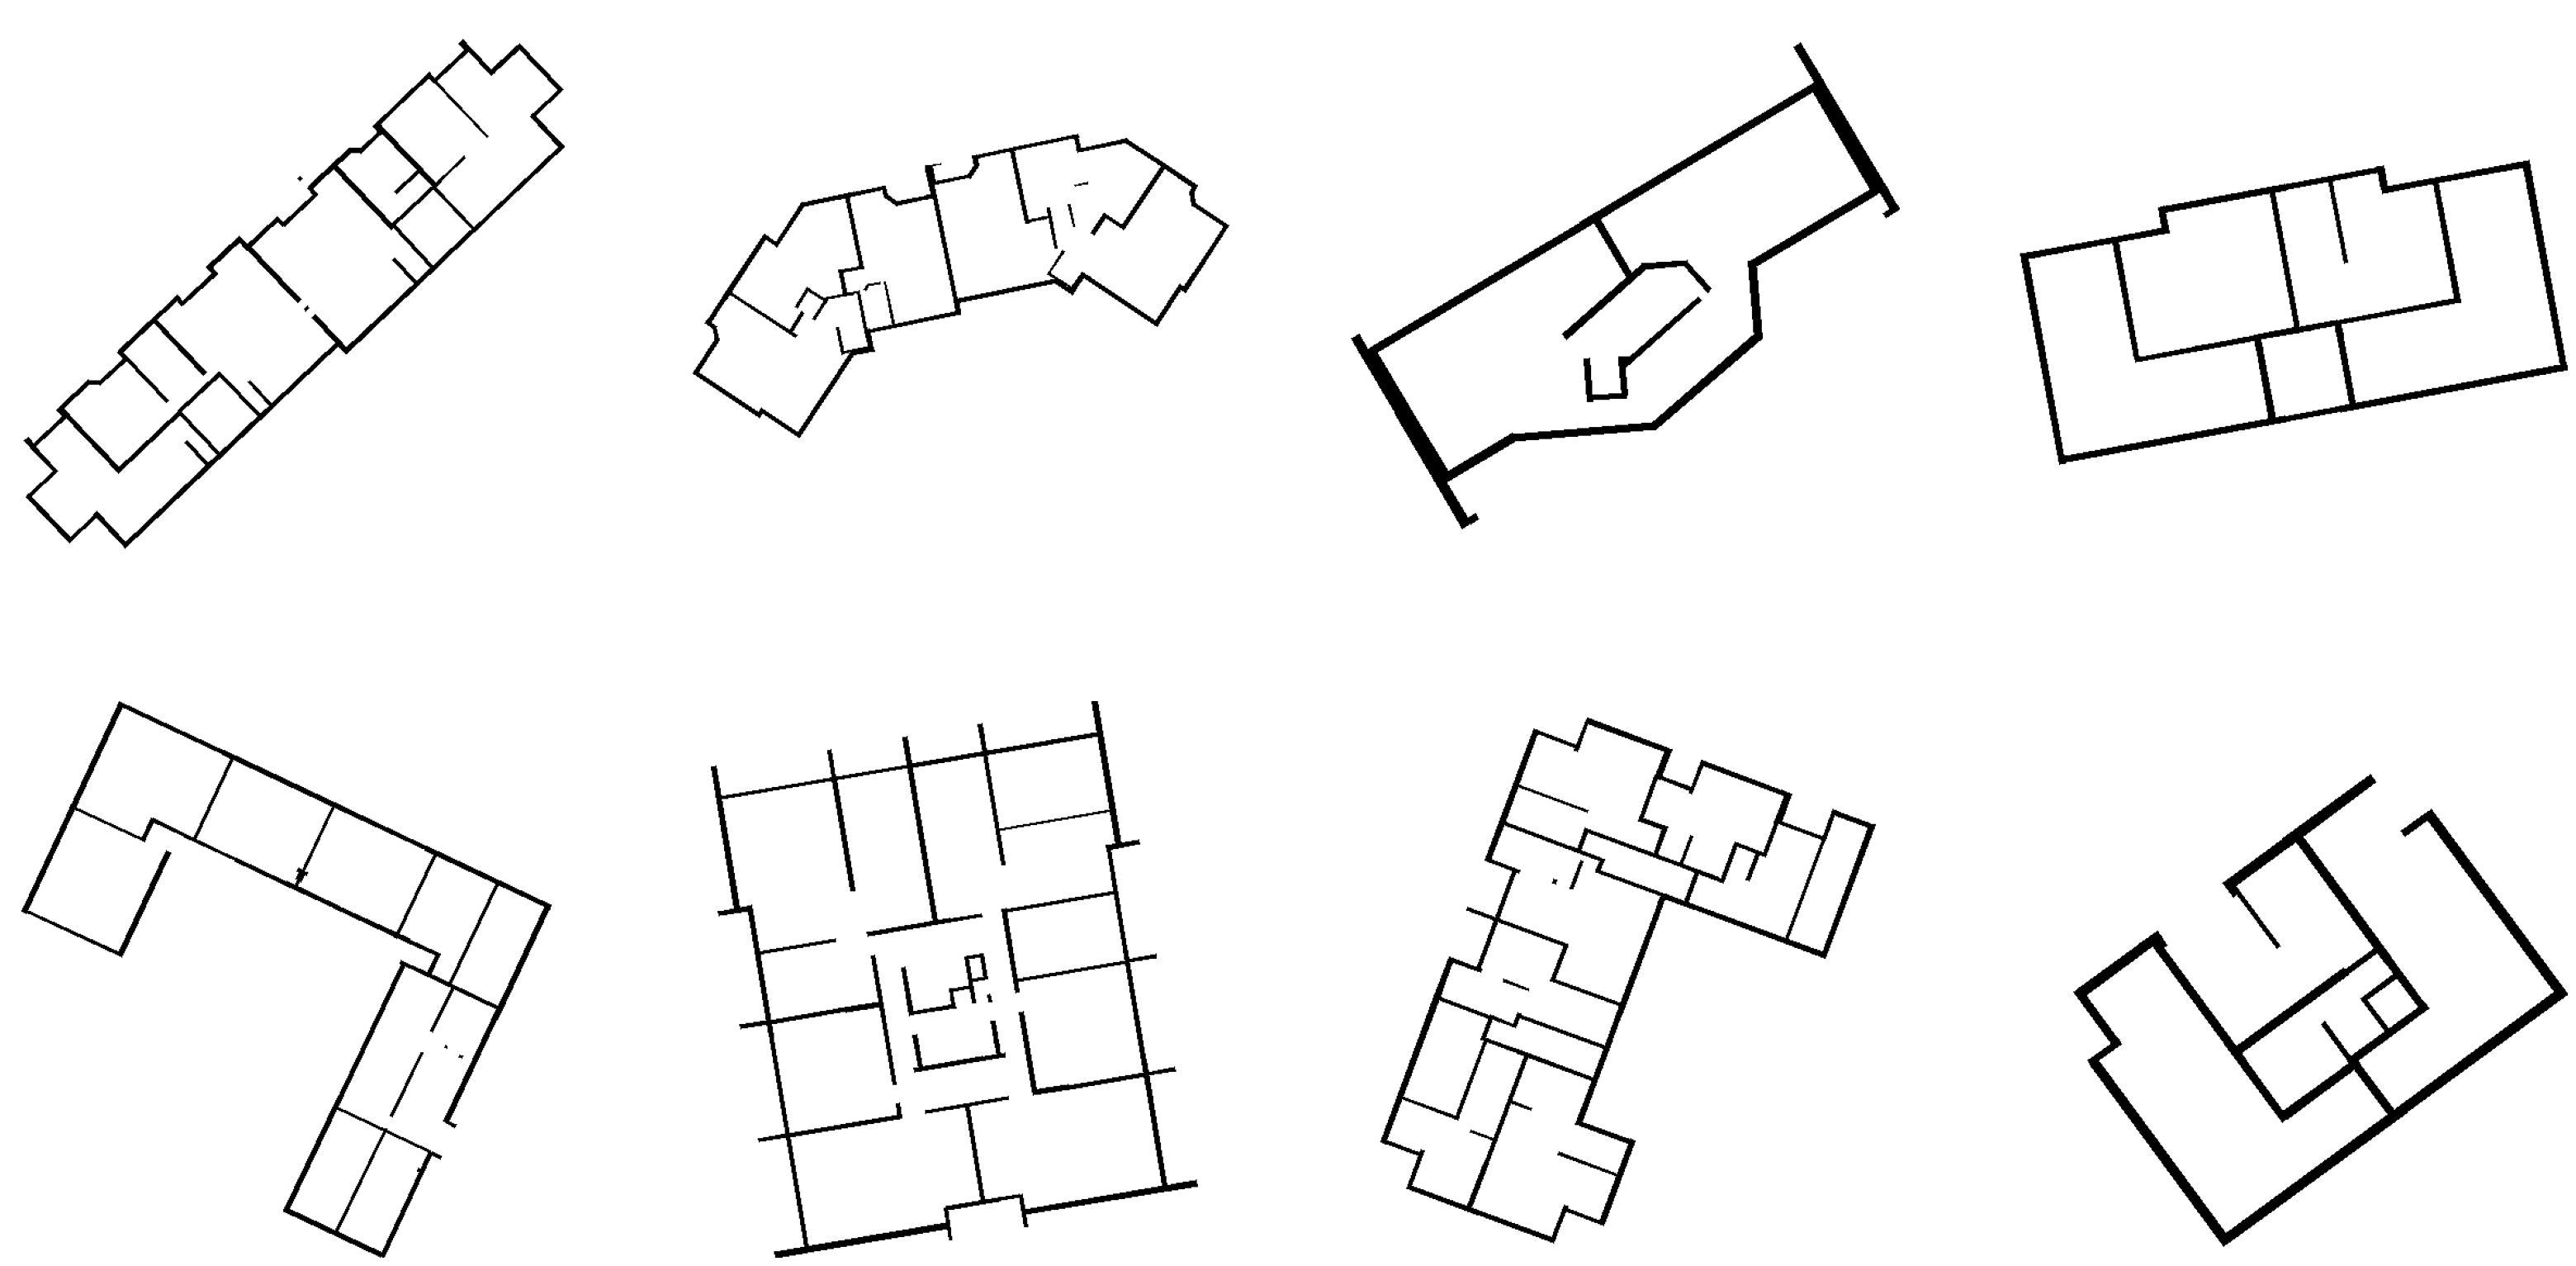

In [2]:
import numpy as np
import matplotlib.pyplot as plt

ids = [63, 2478, 122, 3194, 2193, 167, 446, 2584]

# set up figure
fs = 10
fig, axs = plt.subplots(2, 4, figsize=(fs*4, fs*2))
axs = axs.flatten()

for i, id in enumerate(ids):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # get structural components
    stack = np.load(os.path.join(path["struct_in"], f'{id}.npy'))

    # channel 1: structural components
    # note: channel 2 and 3 are x and y locations
    #   this holds for "full_out" as well
    struct = stack[..., 0].astype(np.uint8)
    ax.imshow(struct, cmap='gray')

### Required zoning access graph

ID    63:	Graph with 54 nodes and 52 edges
ID  2478:	Graph with 58 nodes and 62 edges
ID   122:	Graph with 21 nodes and 21 edges
ID  3194:	Graph with 32 nodes and 33 edges
ID  2193:	Graph with 53 nodes and 49 edges
ID   167:	Graph with 54 nodes and 58 edges
ID   446:	Graph with 68 nodes and 68 edges
ID  2584:	Graph with 26 nodes and 27 edges


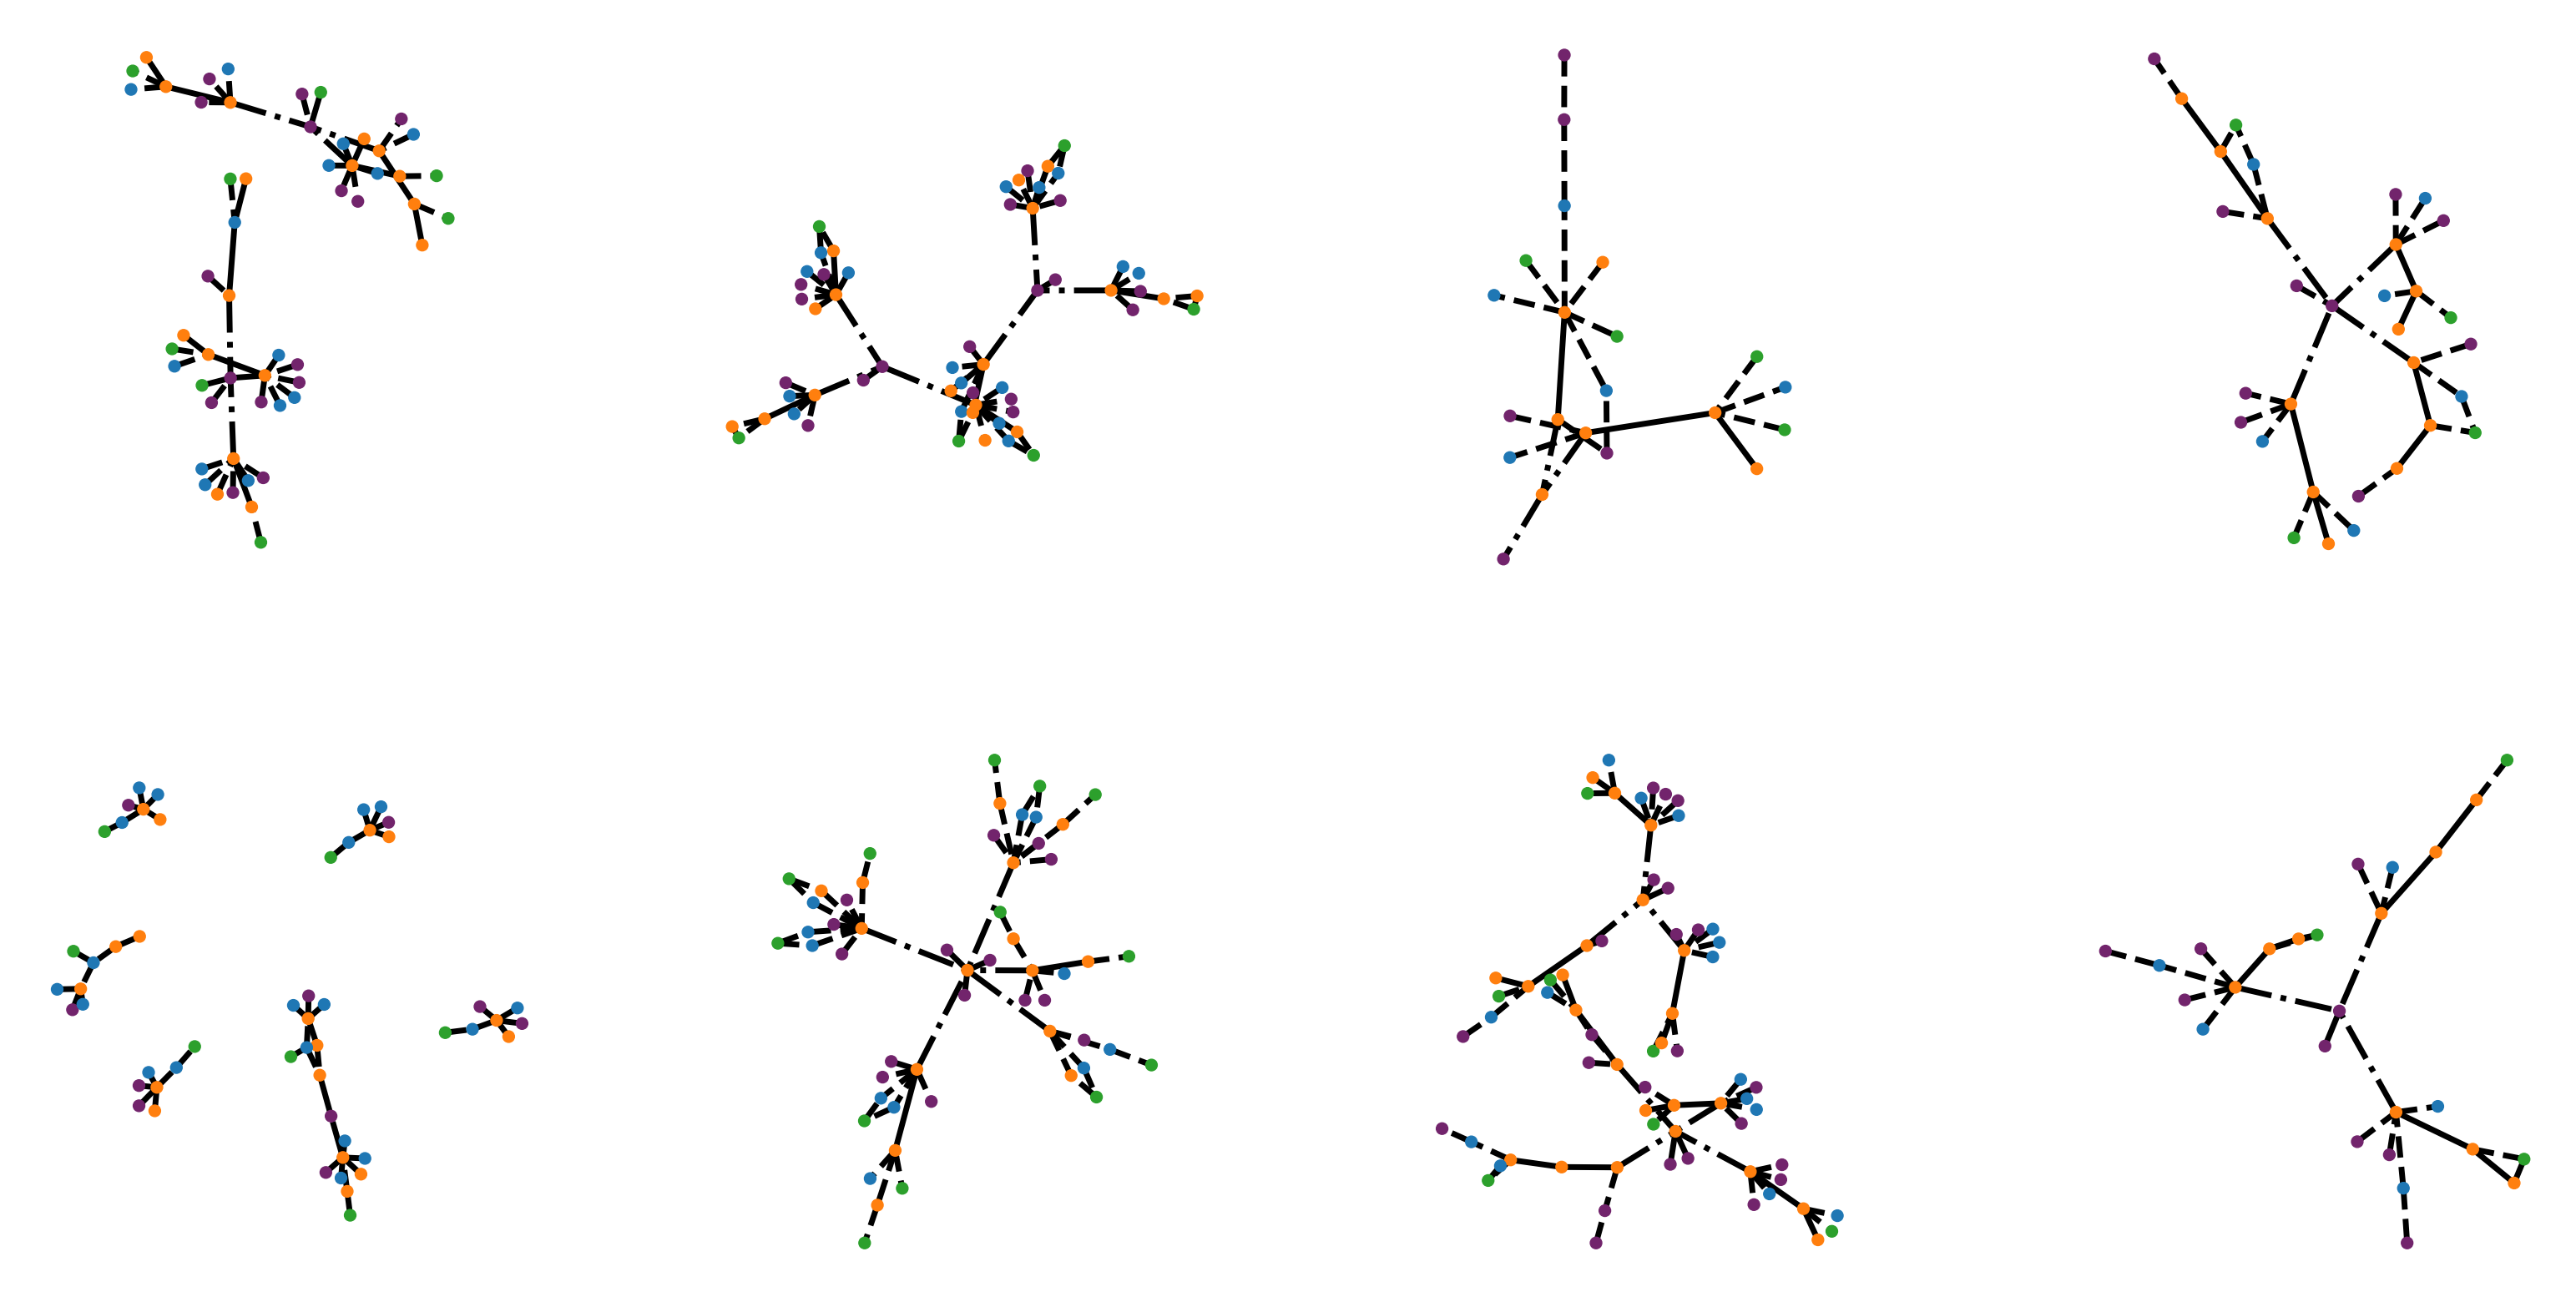

In [3]:
from utils import load_pickle
from constants import ZONING_NAMES, CMAP_ZONING
from plot import plot_graph

# set up figure
fs = 10
fig, axs = plt.subplots(2, 4, figsize=(fs*4, fs*2))
axs = axs.flatten()

for i, id in enumerate(ids):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # get graph
    graph = load_pickle(os.path.join(path["graph_in"], f'{id}.pickle'))
    print(f'ID{id:6.0f}:\t{graph}')

    # plot graph
    # coloring is based on our own colormap "CMAP_ZONING"
    colors = [np.array(CMAP_ZONING(n)).reshape(1,4) for _, n in graph.nodes('zoning_type')]
    plot_graph(graph, ax, c_node=colors, dw_edge=True, c_edge=['black']*4, node_size=fs*10, edge_size=fs/2)

### Full output layout

In [4]:
from constants import ROOM_NAMES, CMAP_ROOMTYPE

class_mapping = {cat: index for index, cat in enumerate(ROOM_NAMES)}
CLASSES = list(map(class_mapping.get, ROOM_NAMES))

# helper function to colorize floor plan
def colorize_floorplan(img, classes, cmap):

    """
    Colorizes an integer-valued image (multi-class segmentation mask)
    based on a pre-defined cmap colorset.
    """

    h, w = np.shape(img)
    img_c = (np.ones((h, w, 3)) * 255).astype(int)
    for cat in classes:
        color = np.array(cmap(cat))[:3] * 255
        img_c[img == cat, :] = (color).astype(int)

    return img_c

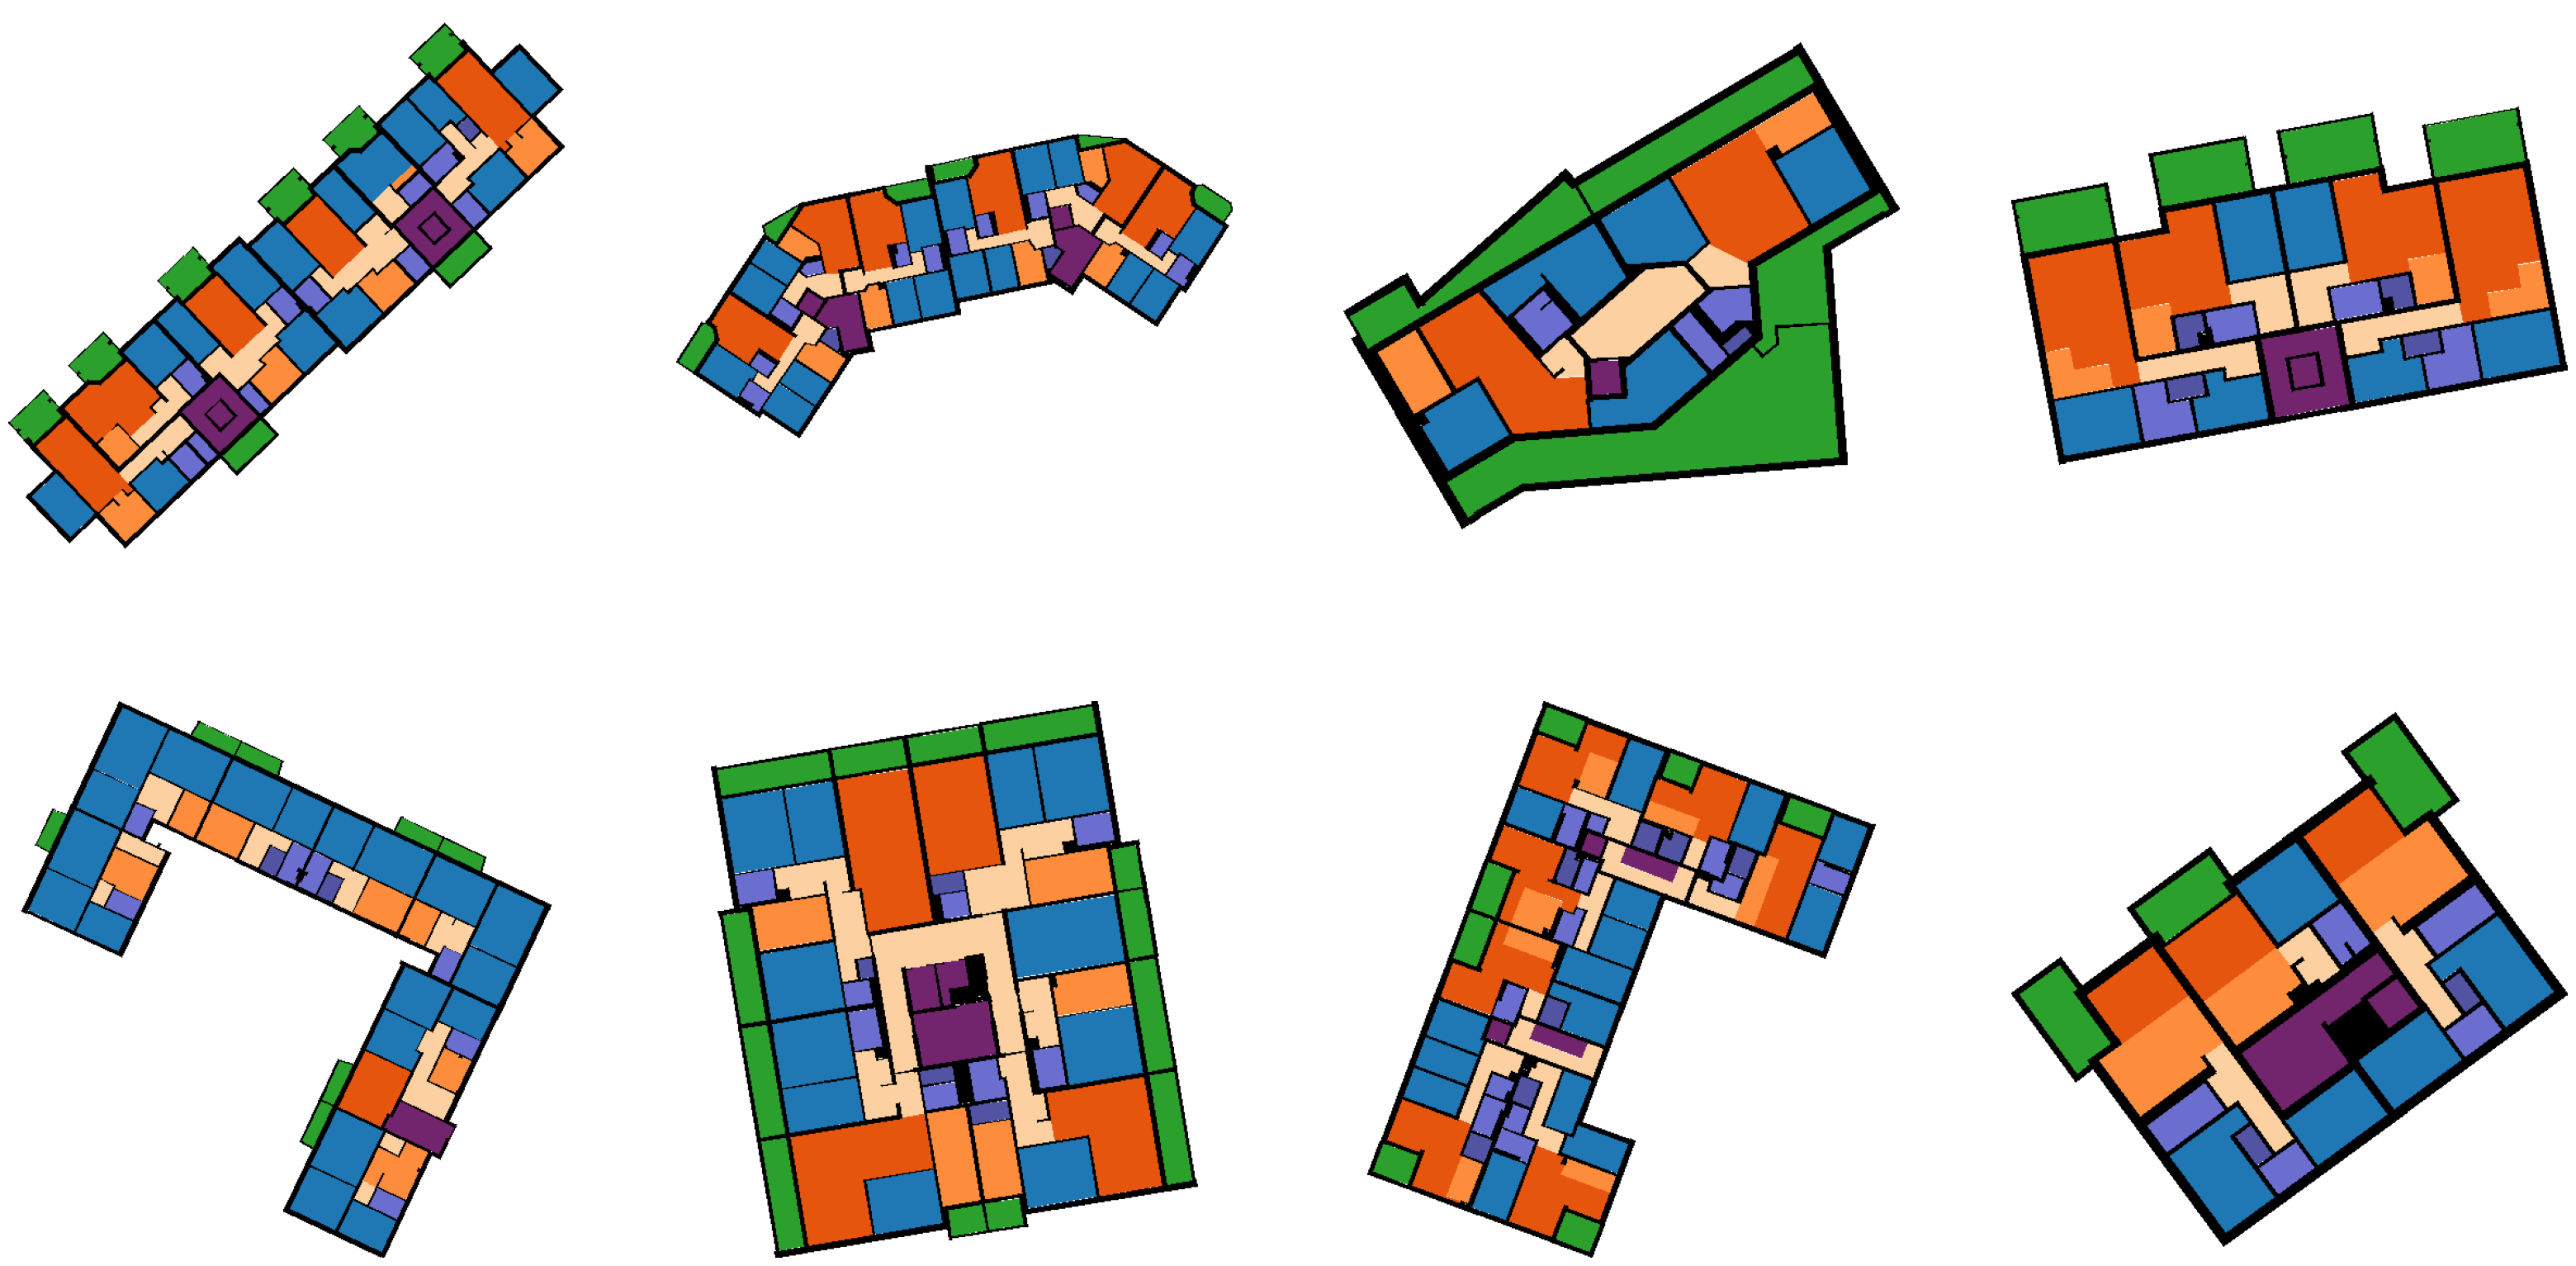

In [5]:
# set up figure
fs = 10
fig, axs = plt.subplots(2, 4, figsize=(fs*4, fs*2))
axs = axs.flatten()

for i, id in enumerate(ids):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # get structural components
    stack = np.load(os.path.join(path["full_out"], f'{id}.npy'))

    # channel 1: structural components
    # note: channel 2 and 3 are x and y locations
    #   this holds for "full_out" as well
    img = stack[..., 0].astype(np.uint8)
    ax.imshow(colorize_floorplan(img, classes=CLASSES, cmap=CMAP_ROOMTYPE))

### Roomtype access graph

ID    63:	Graph with 54 nodes and 52 edges
ID  2478:	Graph with 58 nodes and 62 edges
ID   122:	Graph with 21 nodes and 21 edges
ID  3194:	Graph with 32 nodes and 33 edges
ID  2193:	Graph with 53 nodes and 49 edges
ID   167:	Graph with 54 nodes and 58 edges
ID   446:	Graph with 68 nodes and 68 edges
ID  2584:	Graph with 26 nodes and 27 edges


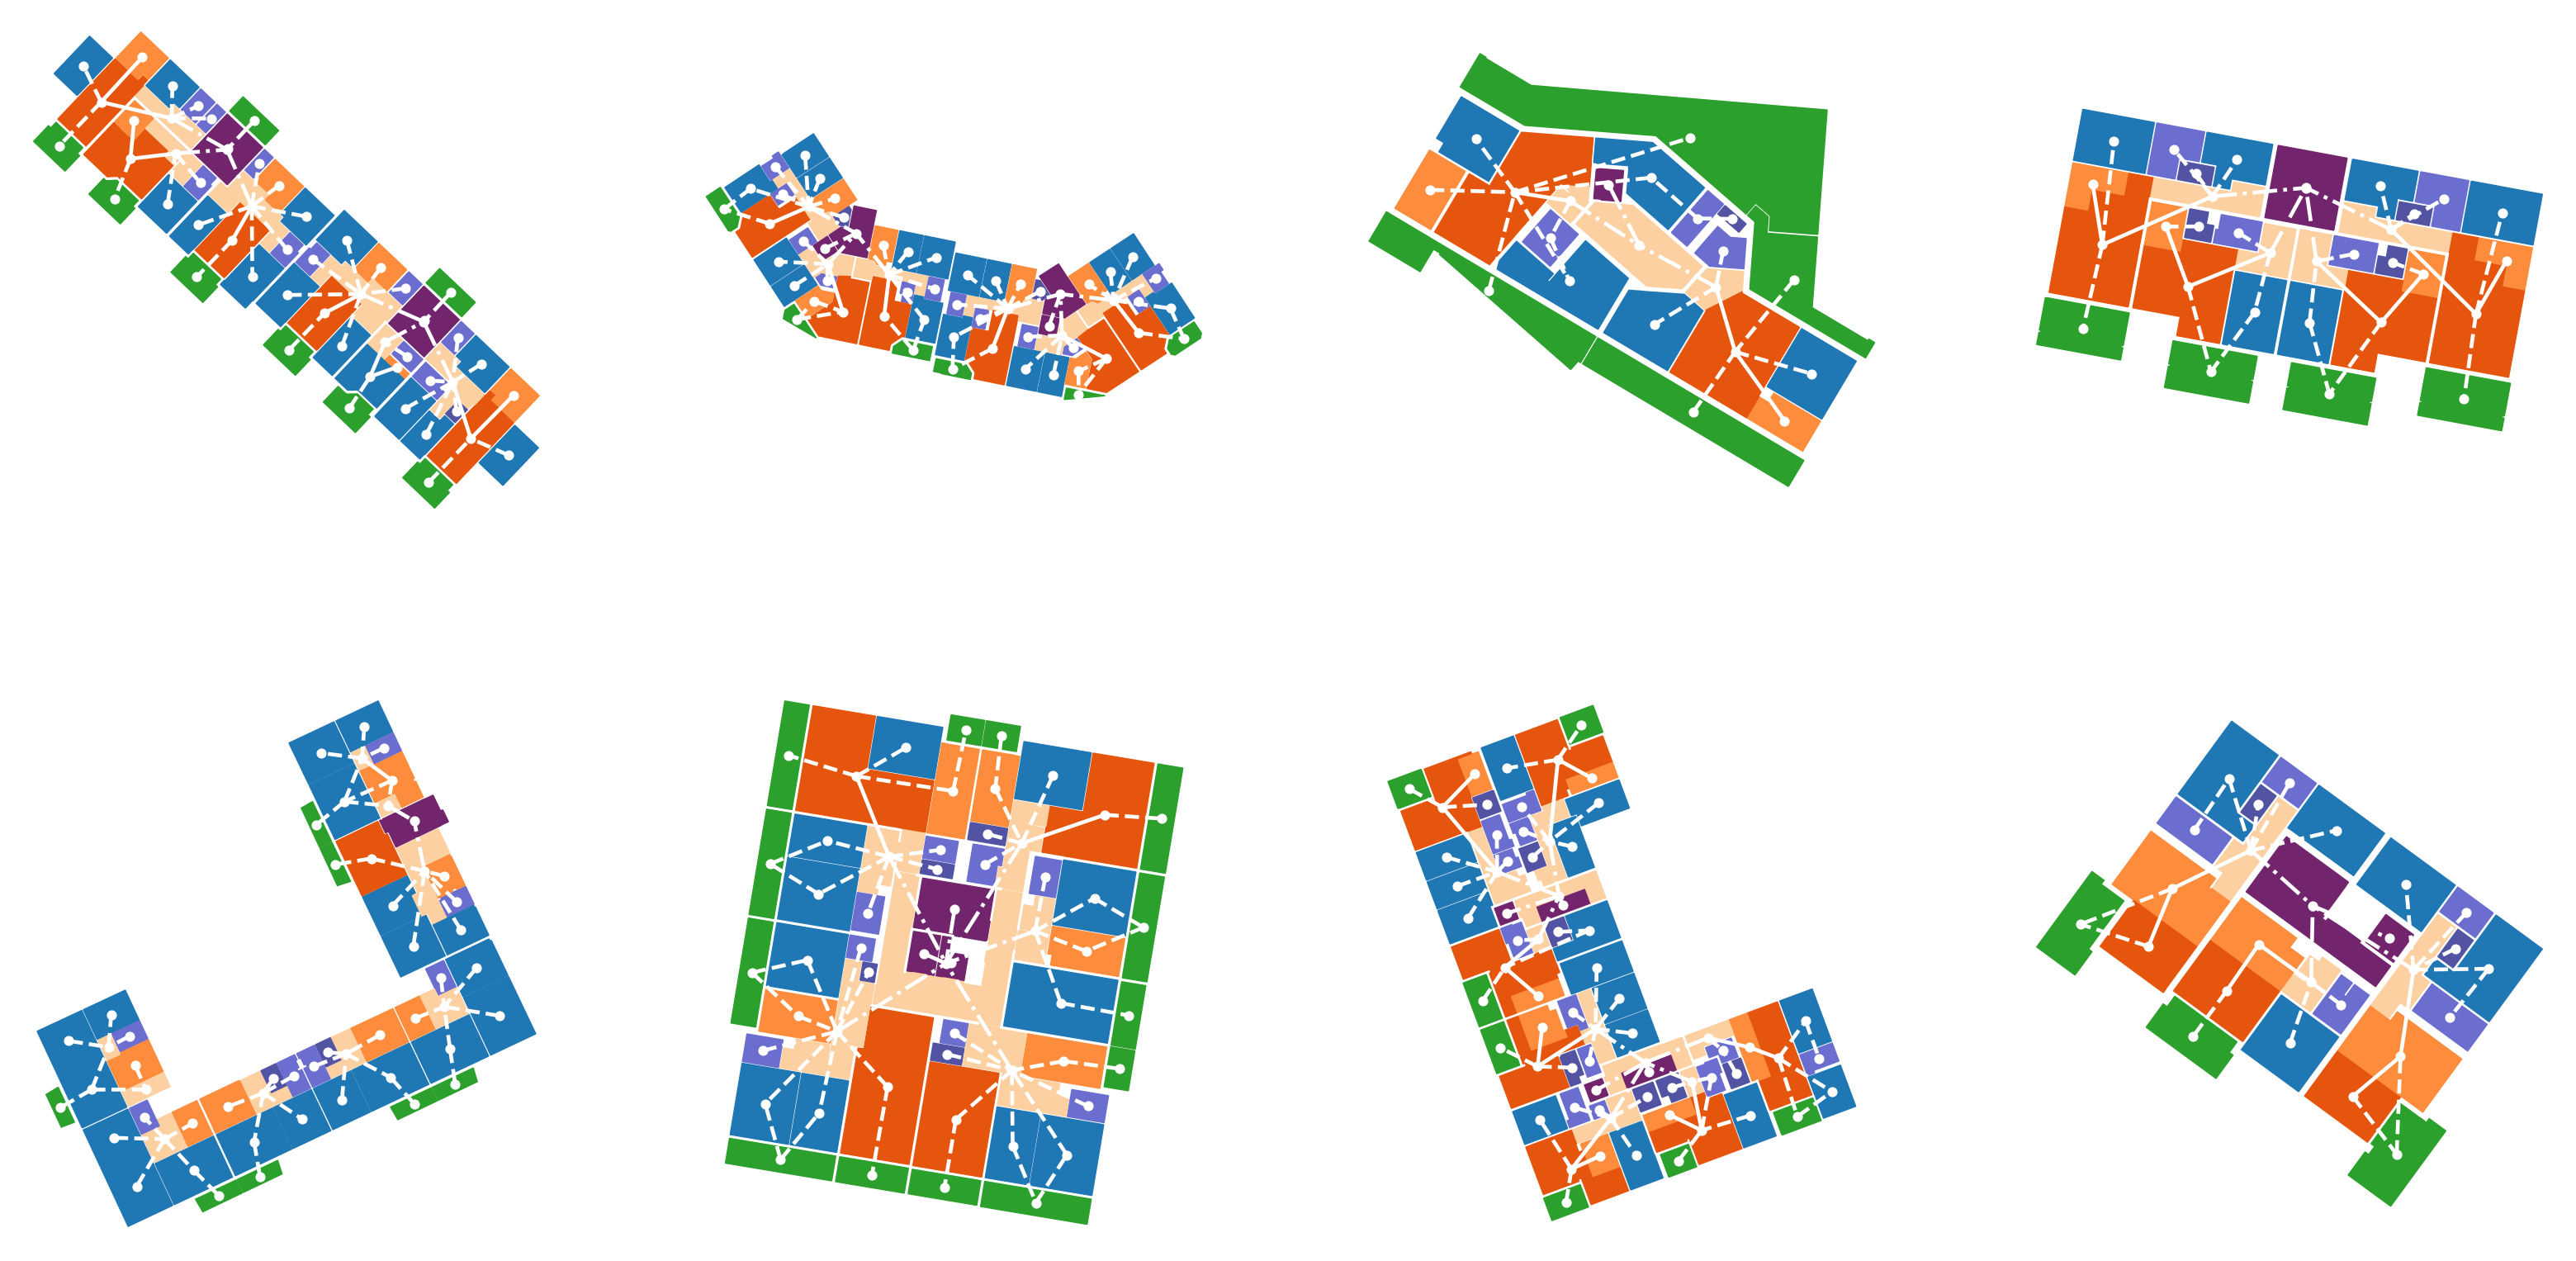

In [7]:
from shapely.geometry import Polygon
from plot import plot_polygon

# set up figure
fs = 10
fig, axs = plt.subplots(2, 4, figsize=(fs*4, fs*2))
axs = axs.flatten()

for i, id in enumerate(ids):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # get graph
    graph = load_pickle(os.path.join(path["graph_out"], f'{id}.pickle'))
    print(f'ID{id:6.0f}:\t{graph}')

    # plot full layout (similar to image)
    # room geometries are in the "geometry" attribute
    rooms = [Polygon(n) for _, n in graph.nodes('geometry')]
    # loop over room and color combination and plot
    colors = [np.array(CMAP_ROOMTYPE(n)).reshape(1,4) for _, n in graph.nodes('room_type')]
    [plot_polygon(ax, room, fc=color, ec=color) for room, color in zip(rooms, colors)]

    # plot graph
    # coloring is based on our own colormap "CMAP_ROOMTYPE"
    # positioning of the nodes are in the "centroid" attribute
    pos = {n: np.array(graph.nodes[n]['centroid']) for n in graph.nodes}
    plot_graph(graph, ax, c_node='white', dw_edge=True, c_edge=['white']*4, pos=pos, node_size=fs*6, edge_size=fs/3)

## Pytorch Geometric Dataloader

We suggest using a Pytorch Geometric (PyG) dataloader for creating the graph batches. (More in depth details: https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html.)

A graph batch (`torch_geometic.loader.Dataloader`) is put together differently than an image batch (`torch.utils.data.Dataloader`). The main reason is that image tensors can be simply stacked along a new axis to form the image batch, which is possible because of the size consistency, graphs cannot because of their varying size. Instead, PyG creates a huge graph (batch graph) containing all individual graph instances in the batch. It does so by gradually adding nodes from all instances to the batch graph. To enable which nodes come from which graph instance, PyG adds a new node attribute called 'batch' indicating the origin of the node (0 if coming from the first graph in the batch, 1 for the second, etc.).

To enable loading both graphs and images simultaneously, the image tensors can be added as graph-level attributes. (They will be stacked naturally by PyG !). See example below.

In [40]:
import torch
import torch_geometric as pyg
from utils import load_pickle

class GraphDataset(torch.utils.data.Dataset):
    """
    Graph Dataset. Collects NetworkX graph from a pre-defined folder and
    transforms them to Pytorch Geometric (pyg.data.Data()) instances.
    """
    def __init__(self, path, graph_type = 'zoning'):
        self.graph_path = os.path.join(path, 'graph_in' if 'zoning' in graph_type else 'graph_out')
        self.struct_path = os.path.join(path, 'struct_in')
        self.full_path = os.path.join(path, 'full_out')

        # include graph transformations if you like
        # self.graph_transform = graph_transform

    def __getitem__(self, index):

        # get access graph (name is index)
        graph_nx = load_pickle(os.path.join(self.graph_path, f'{index}.pickle'))

        # add images as graph attributes
        struct = np.load(os.path.join(self.struct_path, f'{index}.npy'))
        full = np.load(os.path.join(self.full_path, f'{index}.npy'))
        graph_nx.graph['struct'] = struct[np.newaxis, ...]
        graph_nx.graph['full'] = full[np.newaxis, ...]

        # transform networkx graph to pytorch geometric graph
        graph_pyg = pyg.utils.from_networkx(graph_nx)

        # transform graph if you like
        # graph_pyg = self.graph_transform(graph_pyg)

        return graph_pyg

    def __len__(self):
        return len(os.listdir(self.graph_path))

In [41]:
from torch_geometric.loader import DataLoader

# set batch size, dataset, and dataloader
bs = 16
dataset = GraphDataset(path["full"], graph_type='zoning')
dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

In [44]:
# create a data iteration object and print the batch
dataiter = iter(dataloader)
graph_batch = next(dataiter)
print(graph_batch)

DataBatch(edge_index=[2, 1024], zoning_type=[503], connectivity=[16], struct=[16, 512, 512, 3], full=[16, 512, 512, 3], num_nodes=503, batch=[503], ptr=[17])


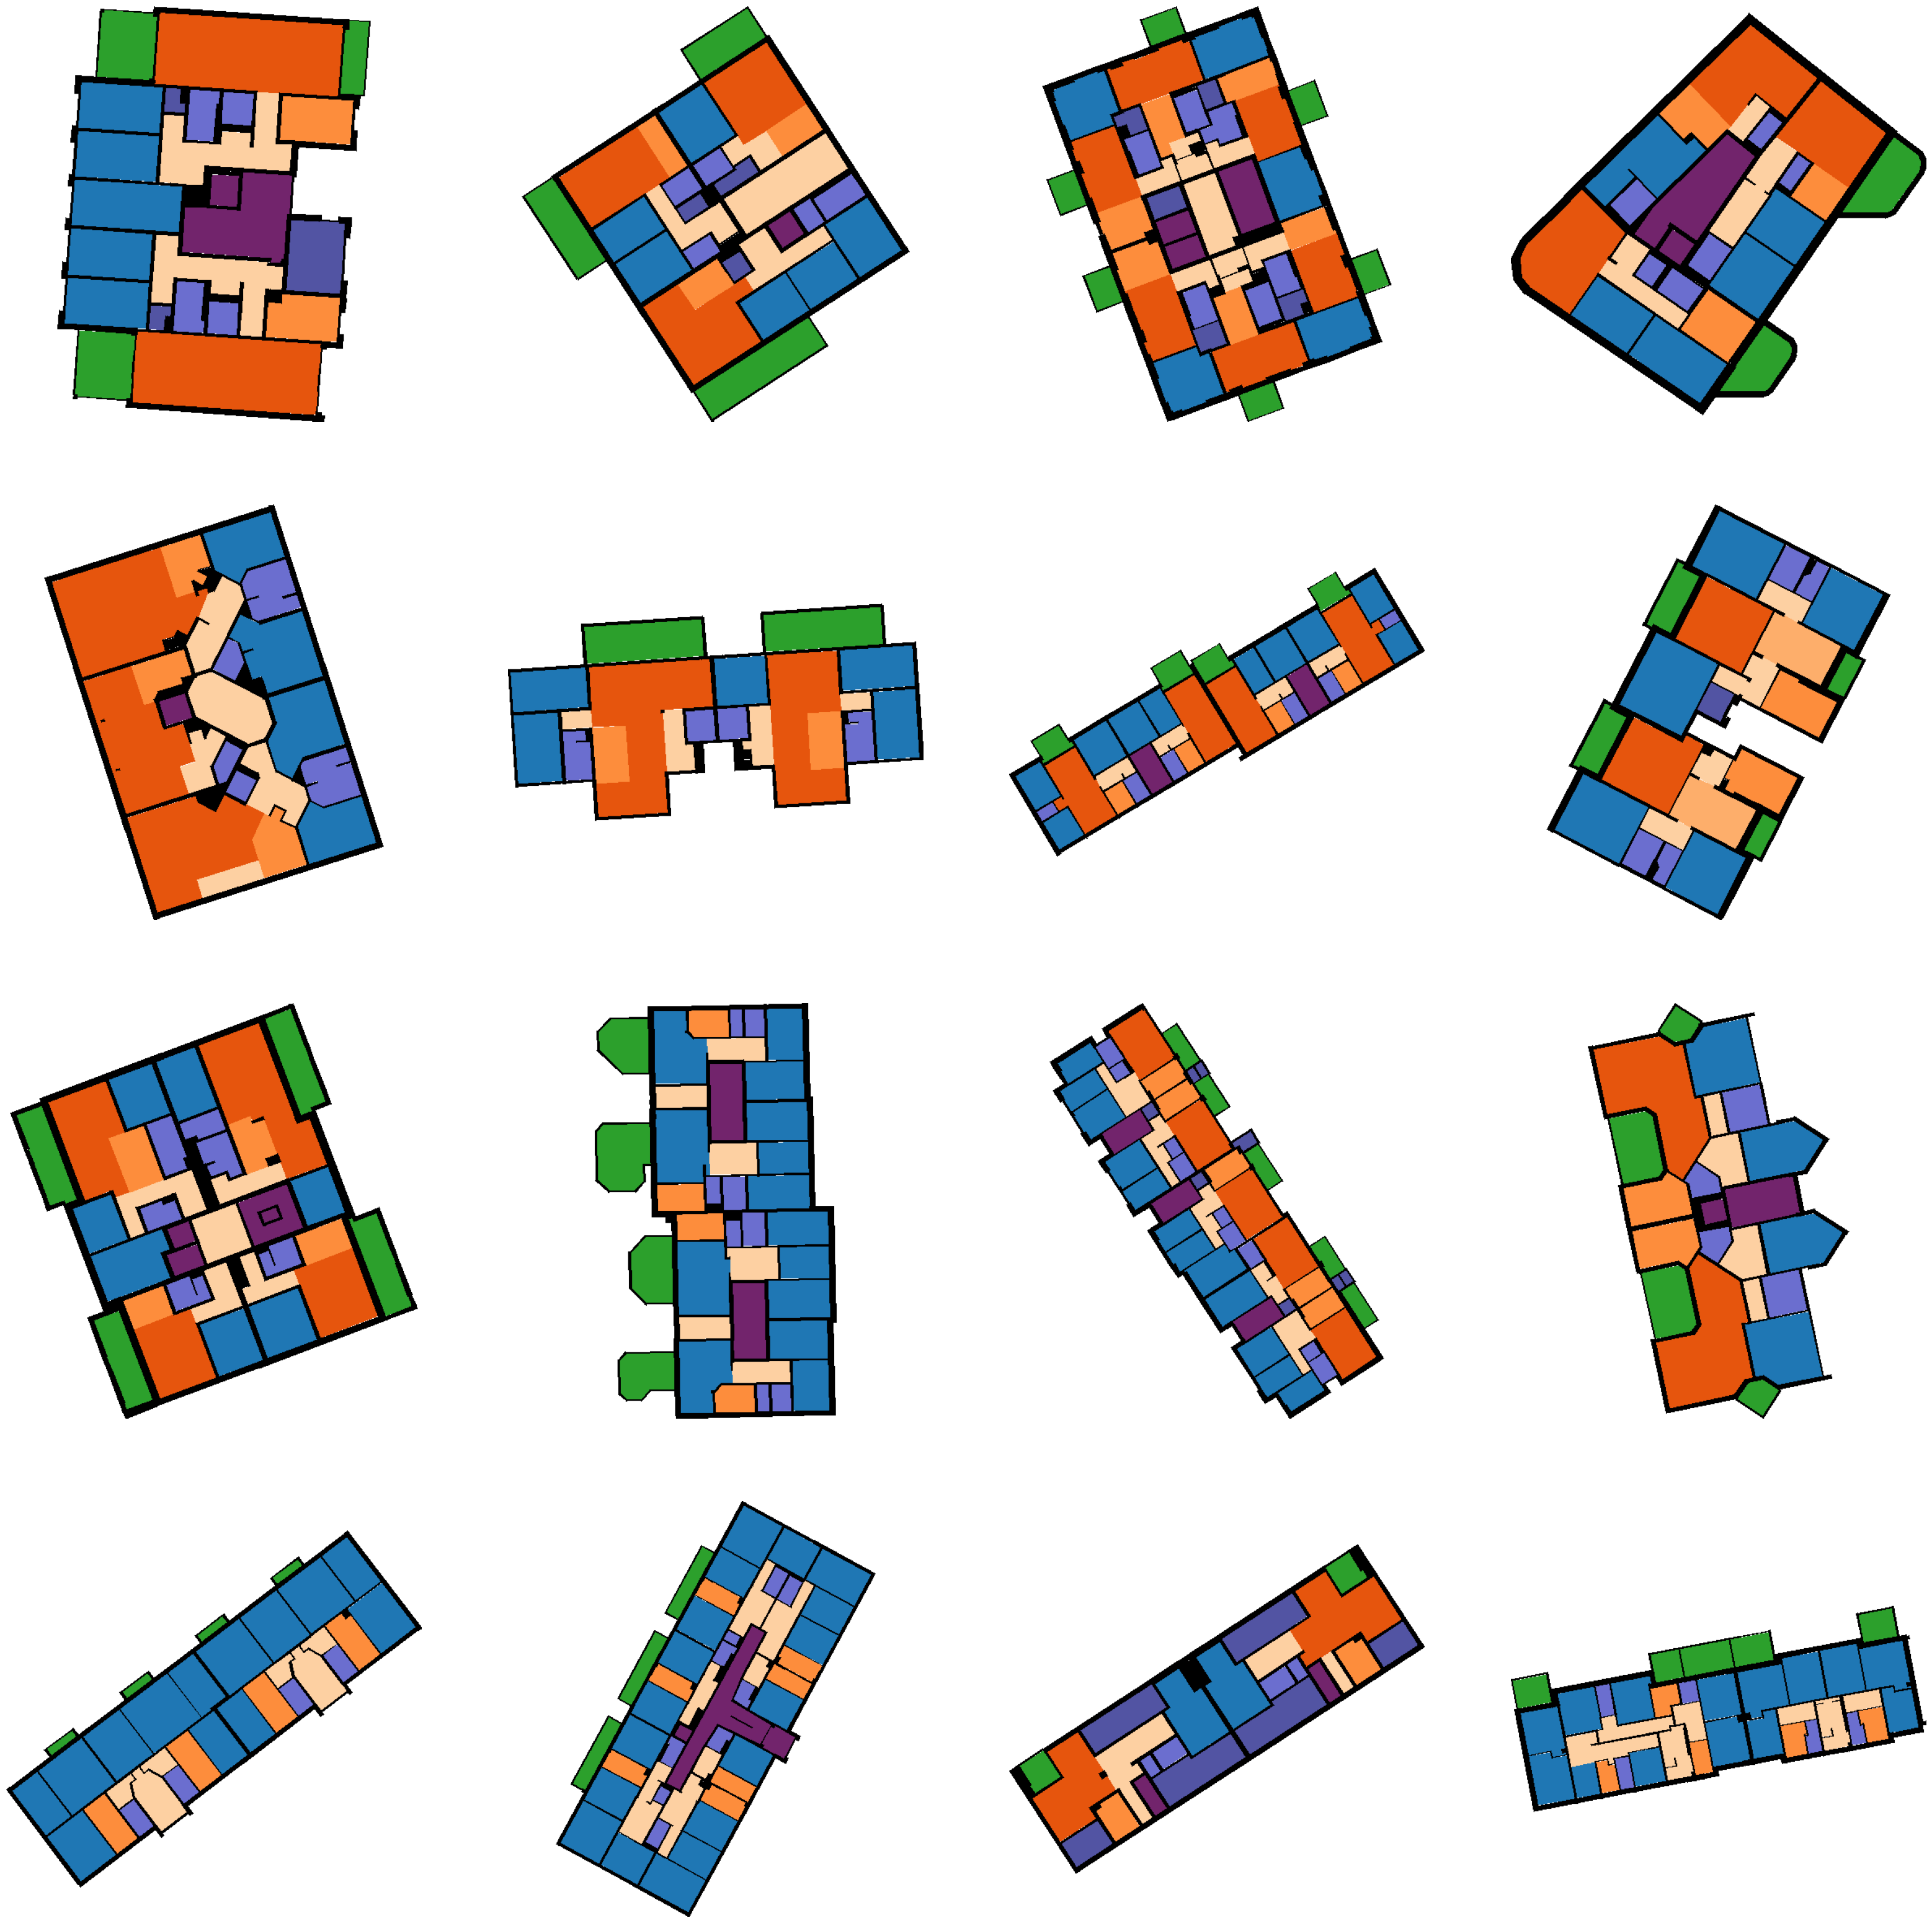

In [57]:
# getting information out of the graph; here extract and plot full floor plans

CLASSES = list(map(class_mapping.get, ROOM_NAMES))

# set up figure
fs = 10
n = int(np.ceil(np.sqrt(bs)))
fig, axs = plt.subplots(n, n, figsize=(fs*n, fs*n))
axs = axs.flatten()

for i in range(bs):

    # set axis
    ax = axs[i]
    _ = [ax.axis('off'), ax.axes.set_aspect('equal')]

    # get full layout (attributes can be called liked functions !)
    struct = graph_batch.full[i, :, :, 0].clone().detach().numpy().astype(np.uint8)  # recall that you need the 1st channel only

    # plot layout
    ax.imshow(colorize_floorplan(struct, classes=CLASSES, cmap=CMAP_ROOMTYPE))

### Pairs of graphs

If you want to use graph pairs (input + output), *e.g.*, when you need the full graph output for backpropagation when doing node-wise prediction of the geometries and room-types in some graph machine learning setting, have a look [here](https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html#pairs-of-graphs) to create a dataloader that outputs pair-wise graphs. (You could instead as well combine both graphs and use the 'zoning_type' attribute as input and 'room_type' + 'geometry' as output.)

### Plotting

For plotting (if you want to use the same plotting functions as above), you have to [convert the PyG graphs to NetworkX graphs](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.to_networkx). (Make sure to add the attributes names to-be-retained in the NetworkX graphs !)

Competing in the challenge? Have fun!!